In [1]:
%matplotlib inline


The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

Download [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples.

Then load these datasets.

In [2]:
import os
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def load_data(data_dirs, limit = None):
    assert type(data_dirs) == list
    data = []
    for data_dir in data_dirs:
        data_files = [f for f in os.listdir(data_dir) if f.endswith(".png")]
        for file in data_files:
            path = data_dir + file
            #img = cv2.imread(path)
            img = mpimg.imread(path)
            data.append(img)
            if limit is not None and len(data) >= limit:
                break
        if limit is not None and len(data) >= limit:
                break
    return data

In [3]:
# load non-vehicles data
non_vehicles = load_data([
    "dataset/non-vehicles/Extras/", # 64 * 64
    "dataset/non-vehicles/GTI/"
])
#], limit = 500)

print(len(non_vehicles))


8968


In [4]:
# load vehicles data. Image type is png (0-1)
vehicles = load_data([
    "dataset/vehicles/GTI_Far/",
    "dataset/vehicles/GTI_Left/",
    "dataset/vehicles/GTI_MiddleClose/",
    "dataset/vehicles/GTI_Right/",
    "dataset/vehicles/KITTI_extracted/"
])
print(len(vehicles)) # 8792

8792


Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


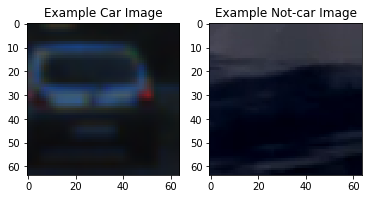

In [5]:
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = car_list[0].shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = car_list[0].dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(vehicles, non_vehicles)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(vehicles))
notcar_ind = np.random.randint(0, len(non_vehicles))
    
# Read in car / not-car images
car_image = vehicles[car_ind]
notcar_image = non_vehicles[notcar_ind]


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

### Extract Hog features

In [6]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vector=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        
        features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False, transform_sqrt=False)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=False, feature_vector=feature_vector, transform_sqrt=False)
        return features

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


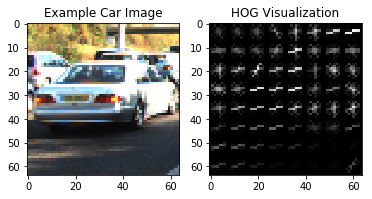

In [7]:

# Generate a random index to look at a car image
ind = np.random.randint(0, len(vehicles))
# Read in the image
image = vehicles[ind]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vector=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


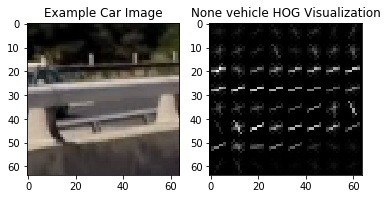

In [8]:
ind2 = np.random.randint(0, len(non_vehicles))
image2 = non_vehicles[ind2]
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
features2, hog_image2 = get_hog_features(gray2, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vector=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image2, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image2, cmap='gray')
plt.title('None vehicle HOG Visualization')

In [9]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

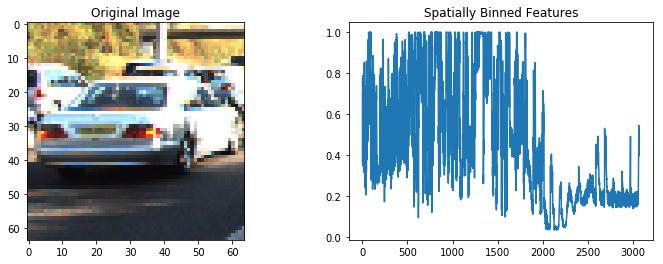

In [10]:
bin_spatial_res = bin_spatial(image)
fig, (ax1, ax2)= plt.subplots(1,2, figsize = (12,4))
ax1.imshow(image)
ax1.set_title('Original Image')
ax2.plot(bin_spatial_res)
ax2.set_title('Spatially Binned Features')

Apply a color transform and append binned color features, as well as histograms of color, to  HOG feature vector

In [11]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

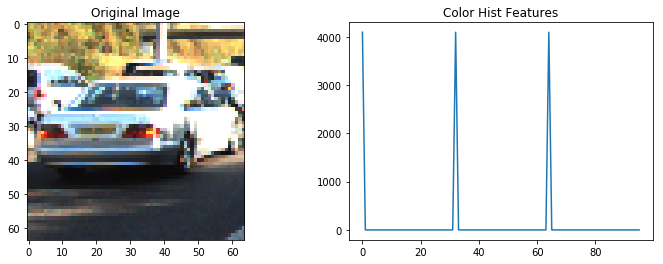

In [12]:
color_hist_res = color_hist(image)
fig, (ax1, ax2)= plt.subplots(1,2, figsize = (12,4))
ax1.imshow(image)
ax1.set_title('Original Image')
ax2.plot(color_hist_res)
ax2.set_title('Color Hist Features')

In [13]:

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vector=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vector=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [14]:

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='BGR', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = single_img_features(image, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        features.append(file_features)
    # Return list of feature vectors
    return features

Explore the feature extracting results.

In [15]:
#color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
color_space = 'YUV'
#orient = 9  # HOG orientations
orient = 11
#pix_per_cell = 8 # HOG pixels per cell
pix_per_cell = 16
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
#spatial_size = (32, 32)
#spatial_size = (64, 64) 
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
#spatial_feat = False # Spatial features on or off

hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 600] # Min and max in y to search in slide_window()

car_features = extract_features(vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(non_vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [16]:
print (len(car_features), len(car_features[0]))

8792 2004


In [17]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
#X,y = load_data()

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


#, validate_data = (test_X, test_y)

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
del car_features, notcar_features

In [19]:

### Normalize data

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
rand_state =20
#import pickle
#pickle.dump(scaled_X, open("scale_obj.pickle", "wb"))
print (scaled_X.shape, y.shape)


(17760, 2004) (17760,)


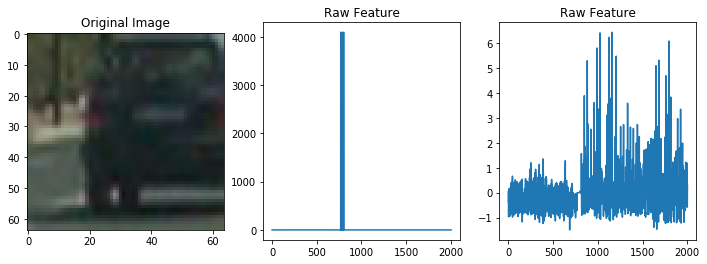

In [20]:
ind = 100
fig, (ax1, ax2, ax3)= plt.subplots(1,3, figsize = (12,4))
ax1.imshow(vehicles[ind])
ax1.set_title('Original Image')
ax2.plot(X[ind])
ax2.set_title('Raw Feature')
ax3.plot(scaled_X[ind])
ax3.set_title('Raw Feature')

### Build and train model

In [21]:
train_X, test_X, train_y, test_y = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

In [26]:
from sklearn.svm import LinearSVC
from sklearn.externals import joblib

def create_and_train_model(train_X, train_y):
    classifier = LinearSVC()
    classifier.fit(train_X, train_y)
    joblib.dump(classifier, 'model.pkl') 
    return classifier

def load_model(path = 'model.pkl'):
    return joblib.load(path)

In [27]:
# training model online in jupter notebook will cause notebook hang up.
# using offline training instead
classifier = create_and_train_model(train_X, train_y)
#print (test_X[0].shape)
#classifier = load_model('model_64_64.pkl')
print('Test Accuracy of SVC = ', round(classifier.score(test_X, test_y), 4))


Test Accuracy of SVC =  0.9831


Estimate a bounding box for vehicles detected.

In [28]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

In [47]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5), scale = 1):
    img = np.copy(image)
    if scale != 1:
        img = cv2.resize(img, (np.int(img.shape[1]/scale), np.int(img.shape[0]/scale)))
    # If x and/or y start/stop positions not defined, set to image size
    
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            xy_window = (int(xy_window[0] * scale), int(xy_window[1]*scale))
            startx = int((xs*nx_pix_per_step + x_start_stop[0]) *scale)
            endx = startx + xy_window[0]
            starty = int((ys*ny_pix_per_step + y_start_stop[0]) *scale)
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


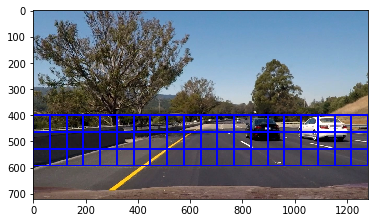

In [70]:
test_img = mpimg.imread("test_images/test6.jpg")

windows = slide_window(test_img, x_start_stop=[None, None],y_start_stop=y_start_stop,  xy_overlap=(0.5, 0.5))
box_img = draw_boxes(test_img, windows)
plt.imshow(box_img)

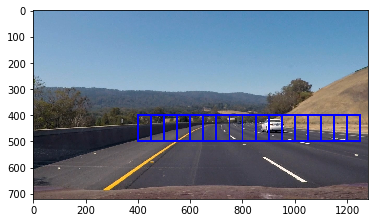

In [104]:
test_img = mpimg.imread("test_images/test3.jpg")

windows = slide_window(test_img, x_start_stop=[400, None],y_start_stop=[400, 500],  xy_overlap=(0.5, 0.5),
                       xy_window = (100,100))
box_img = draw_boxes(test_img, windows)
plt.imshow(box_img)

In [49]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True, img_type='png'):
    if img_type == 'jpg':
        img = img.astype(np.float32)/255
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        #print (spatial_size)
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


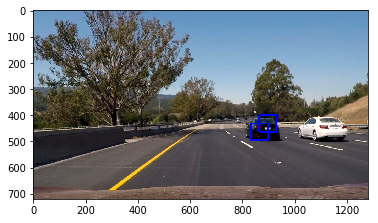

In [61]:
hot_windows = search_windows(test_img, windows, classifier, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, img_type='jpg')
found_box_img = draw_boxes(test_img, hot_windows)
plt.imshow(found_box_img)

217


/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


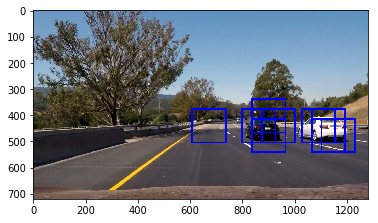

In [71]:
windows2 = slide_window(test_img, x_start_stop=[None, None],y_start_stop=[300, 656],xy_window=(128,128) ,  xy_overlap=(0.7, 0.7))
print (len(windows2))

hot_windows2 = search_windows(test_img, windows2, classifier, X_scaler, color_space= color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, img_type='jpg')
found_box_img = draw_boxes(test_img, hot_windows2)
plt.imshow(found_box_img)

### Multiple Detections and remove false positives

In [72]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [73]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [74]:

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

windows: 38 , how windows: 10 , heat: 720


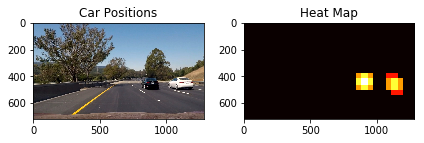

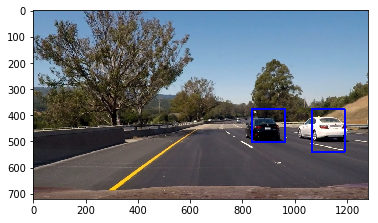

In [75]:
from scipy.ndimage.measurements import label
image = mpimg.imread("test_images/test6.jpg")
hot_windows = hot_windows2
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
 
print ("windows: %d , how windows: %d , heat: %d" %(len(windows), len(hot_windows), len(heat)))    

# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
fig = plt.figure(2)
plt.imshow(draw_img)

Run pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

In [171]:
def pipeline(image, classifier, Xscaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, img_type = 'png'):
    threshold = 1
    draw_image = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    windows1 = slide_window(draw_image, x_start_stop= [200, None],
                            y_start_stop=[400, 600],
                            xy_window = (64,64),
                            xy_overlap=(0.2, 0.2))
    
    windows2 = slide_window(draw_image, x_start_stop= [200, None],
                            y_start_stop=[400, 600],
                            xy_window = (80,80),
                            xy_overlap=(0.2, 0.2))
   
    windows3 = slide_window(draw_image, x_start_stop=[400, None],
                            y_start_stop=[400, 500],  xy_overlap=(0.2, 0.2),
                       xy_window = (96,96))
    
    windows4 = slide_window(draw_image, x_start_stop=[600, None],
                            y_start_stop=[400, 550],  xy_overlap=(0.2, 0.2),
                       xy_window = (112,112))
    
    windows5 = slide_window(draw_image, x_start_stop= [None, None],
                            y_start_stop=[300, 700],
                            xy_window = (128,128),
                            xy_overlap=(0.2, 0.2))
    
    windows = windows1 + windows2 + windows3 + windows4 + windows5
    
    hot_windows = search_windows(draw_image, windows, classifier,  X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, img_type = img_type)    
    
    heat = add_heat(heat,hot_windows)
    heat = apply_threshold(heat,threshold)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    window_img = draw_labeled_bboxes(draw_image, labels)

    #window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    return window_img

In [176]:
from draw_lane_lines import draw_lane_lines
def process_image(image, classifier = classifier, X_scaler = X_scaler, img_type = 'jpg'):
    draw_image = np.copy(image)
    
    img_bin = pipeline(draw_image, classifier, X_scaler, spatial_size =  (16, 16), img_type = img_type)
    # Add Advanced Lane results 
    img_bin_with_lanes = draw_lane_lines(img_bin)
    return img_bin_with_lanes

Process test examples.

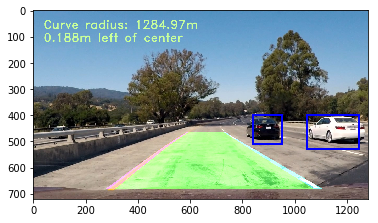

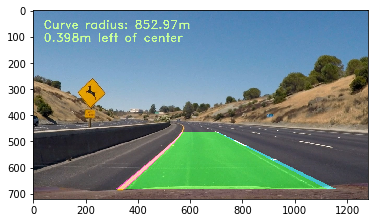

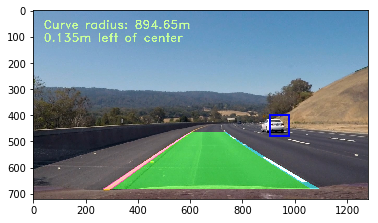

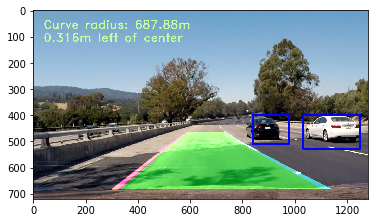

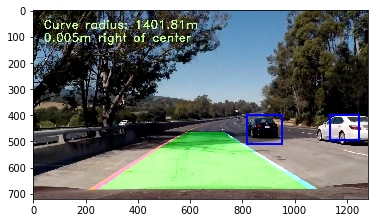

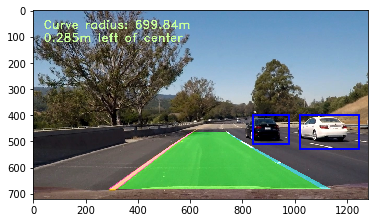

In [177]:

test_images = [
    "test_images/test1.jpg",
    "test_images/test2.jpg",
    "test_images/test3.jpg",
    "test_images/test4.jpg",
    "test_images/test5.jpg",
    "test_images/test6.jpg",
    ]

for i, image_file in enumerate(test_images):
    image = mpimg.imread(image_file)
    #image = cv2.imread(image_file)
    plt.figure(i)
    
    window_img = process_image(image, classifier, X_scaler, img_type = 'jpg')                 
    plt.imshow(window_img)


### Handle video

In [179]:
#import imageio
#imageio.plugins.ffmpeg.download()
#import moviepy.editor as mpy
from moviepy.editor import VideoFileClip
from ipywidgets import interact

test_video_output= 'test_video_output.mp4'
test_video_input = VideoFileClip("test_video.mp4")
processed_video = test_video_input.fl_image(process_image)
%time processed_video.write_videofile(test_video_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:28<00:00,  1.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 32.2 s, sys: 364 ms, total: 32.6 s
Wall time: 30.3 s


In [180]:
project_video_output= 'project_video_output.mp4'
project_video_input = VideoFileClip("project_video.mp4")
processed_video = project_video_input.fl_image(process_image)
%time processed_video.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [15:32<00:00,  1.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 17min 45s, sys: 3.2 s, total: 17min 48s
Wall time: 15min 33s
